In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import torchvision.models as models
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
print(module_path)
sys.path.append(module_path)
import distiller

/home/ec2-user/distiller


In [53]:
BATCH_SIZE = 128

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

trainset = torchvision.datasets.MNIST(root='./mnist-data', train=True,
                                     download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./mnist-data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [55]:
from IPython.display import display, clear_output

def plot_learning(plot_handles, ylabel):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel(ylabel)
    
def plot(log_every, val_log_every, train_loss, val_loss, title):
    clear_output(wait=False)
    plt.gcf().clear()
    iters = np.arange(0,len(train_loss))*log_every
    iters_val = np.arange(0,len(val_loss))*val_log_every
    train_plot, = plt.plot(iters, train_loss, 'r', label="training")
    val_plot, = plt.plot(iters, val_loss, 'b', label="validation")
    
    plot_learning([train_plot, val_plot], "Loss")
    plt.title(title)

    display(plt.gcf())

In [60]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.mask_dict = {}
    
    def set_mask(self, mask_dict):
        self.mask_dict = mask_dict
    
    def mask_params(self, mask_dict=None):
        if mask_dict is not None:
            self.mask_dict = mask_dict
        for param_name, mask in self.mask_dict.items():
            varname, wb = param_name.split('.')[0], param_name.split('.')[1]
            if wb == 'bias':
                continue
            param = getattr(self, varname)
            mask = mask.float()
            mask = mask.to(device)
            param.weight = nn.Parameter(param.weight * mask)
            setattr(self, varname, param)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = LeNet()
net = net.to(device)
print('Using {}'.format(device))
torch.save(net.state_dict(), './checkpoints/lenet_init_e1')

Using cuda


In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

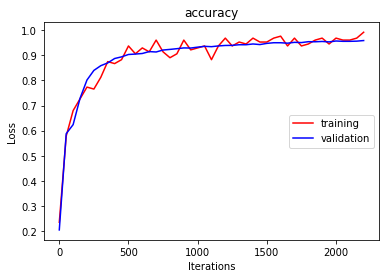

Finished Training


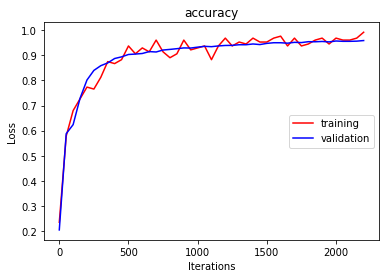

In [73]:
running_loss = 0.0
train_loss = []
val_loss = []
PRINT = 50
N_EPOCH = 5

val_loss = []
train_loss = []
train_acc = []
val_acc = []

for epoch in range(N_EPOCH):  # loop over the dataset multiple times
    print('Starting epoch {}'.format(epoch))
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
        # print statistics
        running_loss += loss.item()
        if (i+1) % PRINT == 0:    # print every PRINT mini-batches
            train_loss.append(running_loss/PRINT)
            
            pred = outputs.argmax(dim=1)
            correct = (targets.eq(pred)).sum()
            acc = correct.float()/len(targets)
            train_acc.append(acc.item())
#             print('[%d, %5d] loss: %.3f' %
#                 (epoch + 1, i + 1, running_loss / PRINT))

            net.eval()
            tcorrect = 0.
            with torch.no_grad():
                for test_idx, (test_inputs, test_labels) in enumerate(testloader, 0):
                    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                    test_outputs = net(test_inputs)
                    test_loss = criterion(test_outputs, test_labels)

                    test_pred = test_outputs.argmax(dim=1)
                    test_correct = (test_labels.eq(test_pred)).sum()
                    tcorrect += test_correct.float()
                print(tcorrect)
                print
                val_acc.append(tcorrect.float()/(len(testloader)*BATCH_SIZE))
                plot(PRINT, PRINT, train_acc, val_acc, title='accuracy')
            net.train()   
            
            running_loss = 0.0
# Compute validation accuracy
    
        
#         hl, = plt.plot([], [])

# def update_line(hl, new_data):
#     hl.set_xdata(numpy.append(hl.get_xdata(), new_data))
#     hl.set_ydata(numpy.append(hl.get_ydata(), new_data))
#     plt.draw()

print('Finished Training')

In [74]:
torch.save(net.state_dict(), './checkpoints/lenet_trained_e2')

In [155]:
# model.load_state_dict(torch.load(PATH))
# model.eval()
net = LeNet()
net.load_state_dict(torch.load('./checkpoints/lenet_trained_e2'))
net = net.to(device)

In [76]:
sparsities = np.arange(0, 1.001, 0.2)
def test_func(model):
    with torch.no_grad():
        running_loss = 0.
        tcorrect = 0.
        for test_idx, (test_inputs, test_labels) in enumerate(testloader, 0):
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs, test_labels)
            running_loss += test_loss.item()
            
            test_pred = test_outputs.argmax(dim=1)
            test_correct = (test_labels.eq(test_pred)).sum()
            tcorrect += test_correct.float()
        acc = (tcorrect.float()/(len(testloader)*BATCH_SIZE)).item()
        loss = running_loss / len(testloader)
        return acc, acc, loss

In [78]:
# sensitivities = \
#     distiller.perform_sensitivity_analysis(model=net, net_params=list(net.state_dict().keys()), sparsities=sparsities, test_func=test_func, group='element')

In [80]:
# distiller.sensitivities_to_png(sensitivities, './experiment_data/lenet_e2_sensitivity.png')

In [161]:
from copy import deepcopy
net_cpy = deepcopy(net)
sparsity_levels = { 'fc1.weight': 0.7, 'fc2.weight': 0.7, 'conv1.weight': 0.0, 'conv2.weight': 0.0 }
pruner = distiller.pruning.SparsityLevelParameterPruner(name="sparsity_pruner", levels=sparsity_levels)
policy = distiller.PruningPolicy(pruner, pruner_args=None)
scheduler = distiller.CompressionScheduler(net_cpy)
scheduler.add_policy(policy, epochs=[0])
scheduler.on_epoch_begin(0)
scheduler.apply_mask()
test_func(model=net_cpy)

(0.9439280033111572, 0.9439280033111572, 0.17232770970256267)

In [162]:
net = LeNet()
net.load_state_dict(torch.load('./checkpoints/lenet_trained_e2'))
net = net.to(device)
# net.set_conv_mask(mask_dict=masks)
test_func(model=net)

(0.9575752019882202, 0.9575752019882202, 0.10095055370084659)

In [25]:
net.mask_params(masks)
test_func(model=net)

(0.0947389230132103, 0.0947389230132103, 2.302871151815487)

In [87]:
def param_count(model, log=False):
    state = model.state_dict()
    total_params = 0
    for param_name in state.keys():
        parameter = state[param_name]
        _n = torch.norm(parameter, p=0)
        if log:
            print(param_name, _n)
        total_params += _n
    return total_params
# torch.norm(net_cpy.state_dict()['fc1.weight'], p=0)/torch.norm(net.state_dict()['fc1.weight'], p=0)

In [163]:
param_count(net_cpy)

tensor(147580., device='cuda:0')

In [164]:
param_count(net_cpy, log=True)/param_count(net)

conv1.weight tensor(500., device='cuda:0')
conv1.bias tensor(20., device='cuda:0')
conv2.weight tensor(25000., device='cuda:0')
conv2.bias tensor(50., device='cuda:0')
fc1.weight tensor(120000., device='cuda:0')
fc1.bias tensor(500., device='cuda:0')
fc2.weight tensor(1500., device='cuda:0')
fc2.bias tensor(10., device='cuda:0')


tensor(0.3423, device='cuda:0')

In [22]:
param_dict = net_cpy.state_dict()
masks = {}
for param_name, param in param_dict.items():
    m = (param == 0)
    masks[param_name] = m

In [36]:
def get_mask_dict(pruned_model):
    param_dict = pruned_model.state_dict()
    _masks = {}
    for param_name, param in param_dict.items():
        m = (param != 0)
        _masks[param_name] = m
    return _masks

In [182]:
from distiller import PruningPolicy, CompressionScheduler
from distiller.pruning import SparsityLevelParameterPruner

def prune_model(_model, old_mask = {}, levels={ 'fc1.weight': 0.2, 'fc2.weight': 0.2, 'conv1.weight': 0.0, 'conv2.weight': 0.0 }):
    if old_mask == {}:
        model = deepcopy(_model)
        pruner = SparsityLevelParameterPruner(name='sparsity_pruner', levels=levels)
        policy = PruningPolicy(pruner, pruner_args=None)
        scheduler = distiller.CompressionScheduler(model)
        scheduler.add_policy(policy, epochs=[0])
        scheduler.on_epoch_begin(0)
        scheduler.apply_mask()
        return model
    else:
        model = deepcopy(_model)
        for param_name, mask in old_mask.items():
            name, wb = param_name.split('.')[0], param_name.split('.')[1]
            param = getattr(model, name)
            if wb == 'bias':
                continue
            param[mask] = 1e100
        pruner = SparsityLevelParameterPruner(name='sparsity_pruner', levels=levels)
        policy = PruningPolicy(pruner, pruner_args=None)
        scheduler = distiller.CompressionScheduler(model)
        scheduler.add_policy(policy, epochs=[0])
        scheduler.on_epoch_begin(0)
        scheduler.apply_mask()
        new_masks = {}
        for param_name, param in model.named_parameters():
            new_mask = (param != 0)
            _old_mask = old_mask[param_name]
            combined = new_mask + _old_mask
            combined[combined > 1] = 1
            new_masks[param_name] = combined
        return new_masks

In [121]:
desired_sparsity = 0.05
pct_to_prune = (1 - desired_sparsity)
PRUNE_ROUNDS = 20


In [193]:
# masks['fc1.weight']
net.fc1.weight[masks['fc1.weight']]

tensor([-0.0341, -0.0262,  0.0314,  ..., -0.0268, -0.0310,  0.0344],
       device='cuda:0', grad_fn=<IndexBackward>)

In [127]:
z = pct_to_prune**(1./20)

In [189]:
ticket = LeNet()
# ticket.load_state_dict(torch.load('./checkpoints/lenet_init_e1'))
ticket = ticket.to(device)

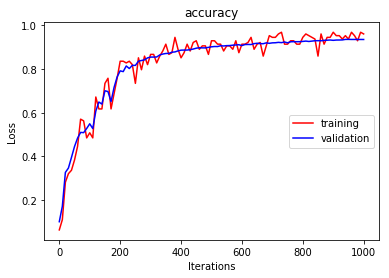

TypeError: only integer tensors of a single element can be converted to an index

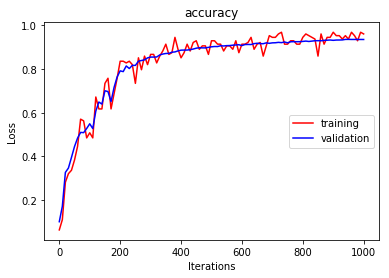

In [190]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ticket.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

ticket.train()
mask = {}
ticket.mask_params()

running_loss = 0.0
train_loss = []
val_loss = []
PRINT = 10
PLOT_EVERY = 10

PRUNE_EVERY = 50
PRUNE_START = 500

N_EPOCH = 10

val_loss = []
train_loss = []
train_acc = []
val_acc = []

for epoch in range(N_EPOCH):  # loop over the dataset multiple times
    print('Starting epoch {}'.format(epoch))
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = ticket(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        ticket.mask_params(mask)
        
        if (i+1) > PRUNE_START or epoch > 1:
            if (i+1) % PRUNE_EVERY == 0:
                old_mask = deepcopy(mask)
                pruned = prune_model(ticket, old_mask=old_mask)
                mask = get_mask_dict(pruned)
                if old_mask != {}:
                    print(mask['conv1.weight'] == old_mask['conv1.weight'])
                ticket.mask_params(mask)
    
        # print statistics
        running_loss += loss.item()
        if (i+1) % PRINT == 0:    # print every PRINT mini-batches
            train_loss.append(running_loss/PRINT)
            
            pred = outputs.argmax(dim=1)
            correct = (targets.eq(pred)).sum()
            acc = correct.float()/len(targets)
            train_acc.append(acc.item())
#             print('[%d, %5d] loss: %.3f' %
#                 (epoch + 1, i + 1, running_loss / PRINT))

            ticket.eval()
            tcorrect = 0.
            with torch.no_grad():
                for test_idx, (test_inputs, test_labels) in enumerate(testloader, 0):
                    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                    test_outputs = ticket(test_inputs)
                    test_loss = criterion(test_outputs, test_labels)

                    test_pred = test_outputs.argmax(dim=1)
                    test_correct = (test_labels.eq(test_pred)).sum()
                    tcorrect += test_correct.float()
                print
                val_acc.append(tcorrect.float()/(len(testloader)*BATCH_SIZE))
                if (i+1) % PLOT_EVERY == 0:
                    plot(PRINT, PRINT, train_acc, val_acc, title='accuracy')
            ticket.train()   
            
            running_loss = 0.0
            
print('Finished retraining')

In [34]:
len(trainloader)

469

In [210]:
m1 = masks['conv1.weight']
m1 = m1.to(device)
param = net.state_dict()['conv1.weight']
param = param.to(device)

In [13]:
k, p = 5, .75
z = (p**(1/k))

0.05591248870509802